In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [55]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [56]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, distinct, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Msrm = Base.classes.measurement
Stat = Base.classes.station

In [8]:
#Get a list of column names and types - Measurement
inspector = inspect(engine)
msrm_columns = inspector.get_columns('measurement')
for r in msrm_columns:
    print(r['name'], r['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Get a list of column names and types - Station
stat_columns = inspector.get_columns('station')
for r in stat_columns:
    print(r['name'], r['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [70]:
# Find the most recent date in the data set.
min_date = session.query(Msrm.date).order_by(Msrm.date).first()
min_date

('2010-01-01')

In [84]:
# Find the last date in the data set.
max_date = session.query(Msrm.date).order_by(Msrm.date.desc()).first()
max_date

('2017-08-23')

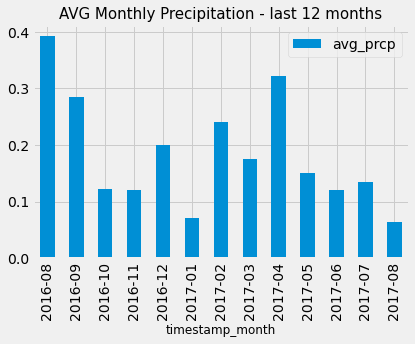

In [136]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

prcp_l12m = engine.execute('''SELECT strftime("%Y-%m",date), AVG(prcp) FROM measurement 
                WHERE date >= ( 
                SELECT DATE(max(date), "-12 months")
                FROM measurement)
                GROUP BY 1
                ''').fetchall()

df = pd.DataFrame(prcp_l12m, columns = ['timestamp_month', 'avg_prcp'])
df.set_index('timestamp_month', inplace = True)
df.plot.bar()
plt.title('AVG Monthly Precipitation - last 12 months', fontsize = 15)
plt.xlabel('timestamp_month', fontsize = 12)
plt.show()





In [ ]:
# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame and set the index to the date column


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()